# Introduction

This notebook explores a dataset that contains data on Kickstarter projects, which are crowdfunding campaigns for creative ideas. Kickstarter projects can either succeed or fail. In this notebook, I will explore the dataset and examine how its different variables affect the success of a Kickstarter project. I will also build and evaluate a suitable model that tries to predict the outcome of a Kickstarter project based on the other variables (or features) in the dataset.

Kickstarter Projects are varied; for example, projects range from films, music, stage shows, comics, video games, food-related projects, board games, journalism, and technology (to just name a few). The general process works like this:

* A Kickstarter project launches with a defined funding goal amount and deadline.
* People make pledges to a Kickstarter project, i.e., an agreement to give a certain amount of funds towards the project’s completion. These people are called backers.
* If the total pledges meet or surpass the project’s funding goal before its deadline, then the project receives funding and the backers are charged their pledged amount.

I use SQLite3 as the database to store the data locally and use both SQL and Python for the analysis. 

Dataset source: [Kaggle](https://www.kaggle.com/datasets/kemical/kickstarter-projects?datasetId=4104&sortBy=voteCount&searchQuery=logistic)

Setup:

In [ ]:
# install libraries and modules
%pip install ipywidgets
%pip install pandas
%pip install numpy
%pip install sqlalchemy
%pip install matplotlib
%pip install seaborn
%pip install squarify
%pip install scipy
%pip install scikit-learn

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import squarify # for treeplot
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import scipy # for statistic tests

In [2]:
# enable jupyter cell to display visualisations
%matplotlib inline 

# allow jupyter notebok to show multiple outputs from same cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
import warnings
# remove distracting warnings on deprecated functions
warnings.filterwarnings("ignore", message="is_categorical_dtype is deprecated")
warnings.filterwarnings("ignore", message="use_inf_as_na option is deprecated")

# Descriptive Exploration

After connecting to the local database file I can now use python to run SQL queries on the SQLite database file.

In [4]:
conn = sqlite3.connect('sql-ks-projects-201801.db')
cur = conn.cursor()

In total, there are 378661 Kickstarer projects in the dataset.

In [5]:
# Save query result
total_kickstarters = pd.read_sql('SELECT COUNT(*) AS Total FROM kickstarter_2018', conn)
# Display amount
print(f"{total_kickstarters['Total'][0]} kickstarters in total.")

378661 kickstarters in total.


### State

The State variable shows the outcome of a Kickstarter project. There are six distinct outcomes. The failed category constitutes the largest portion at roughly 52%, followed by successful at roughly 35%.

In [6]:
# Obtain the total and percentage for each state value
state_distribution = pd.read_sql('''
                                 SELECT state, COUNT(state) AS total, 100 * (
                                        COUNT(state) * 1.0 / (SELECT COUNT(*) AS Total FROM kickstarter_2018)
                                        ) AS percentage
                                 FROM kickstarter_2018
                                 GROUP BY state
                                 ORDER BY percentage DESC
                                 ''', conn)
state_distribution

,state,total,percentage
0,failed,197719,52.215306
1,successful,133956,35.376234
2,canceled,38779,10.241086
3,undefined,3562,0.940683
4,live,2799,0.739184
5,suspended,1846,0.487507


I store the query string below in a variable for future SQL queries to simplify accessing the total Kickstarter projects for calculating percentages. I can use Python to pass this variable to a SQL query and get the results.

In [7]:
total_obs = '(SELECT COUNT(*) AS Total FROM kickstarter_2018)'

### Main Category

The main_category variable shows the type of kickstarter project. The visualisaton below shows the counts of each category. Film and Video are the most common projects, followed by Music, Publishing, and Games. Dance, Journalism, and Crafts are the least common in the dataset.

[Text(0.5, 0, 'Count'),
 Text(0, 0.5, 'Main Categories'),
 Text(0.5, 1.0, 'Count of Main Categories')]

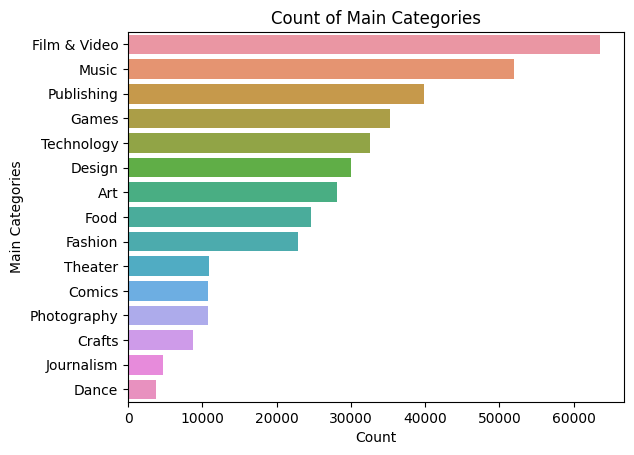

In [8]:
# aggregate by main_category
main_categories = pd.read_sql(f'''
                              SELECT main_category, COUNT(main_category) AS count, 100 * (COUNT(main_category) * 1.0 / {total_obs}) AS percentage 
                              FROM kickstarter_2018
                              GROUP BY main_category
                              ORDER BY count DESC;
                             ''', conn)

# visualise main_category count
cat_bar = sns.barplot(data=main_categories, x='count', y='main_category')
cat_bar.set(xlabel="Count", ylabel="Main Categories", title="Count of Main Categories")

### Category

The main_category variable further branches out into a more specific 'category' variable which has in total 159 unique values.

In [9]:
categories = pd.read_sql('''
                         SELECT category, COUNT(category) AS count
                         FROM kickstarter_2018
                         GROUP BY category
                         ORDER BY count DESC;
                        ''', conn)
# number of categories
len(categories)

159

Showing 159 categories is too large for a table and cumbersome for a single visualisation. My solution is to calculate the total counts for each category and visualise those counts in a violinplot. This plot provides an overall idea of how the frequency of categories differs in the dataset.

The plot exhibits a right skew which indicates a relatively small number of categories are disproportionately represented in a large number of kickstarter projects. Furthermore, a majority of categories appear to be in under 3000 kickstarter projects as the Interquartile Range (IQR), depicted by the thick black bar, spans only a small portion of the x-axis below 3000.

[Text(0.5, 0, 'Frequency of Category'), Text(0.5, 1.0, 'Category Counts')]

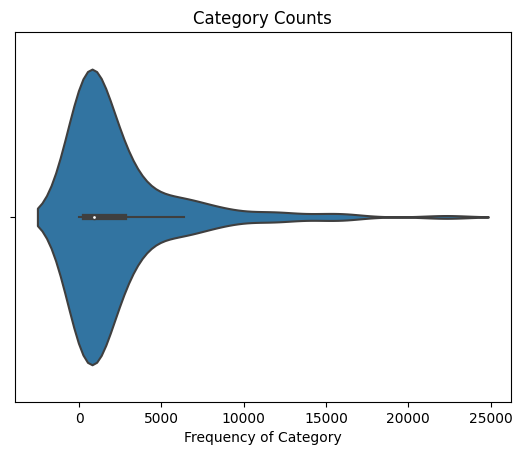

In [10]:
cat_vio = sns.violinplot(data=categories, x='count')
cat_vio.set(xlabel='Frequency of Category', title='Category Counts')

I examine summary statistics from the table below. As the data is right-skewed and has some very high values, the IQR and median are better measures of variation and central tendency respectively. The IQR is 2417, which means that about half of the categories (79) are in between 333 and 2750 Kickstarter projects. This is a small range compared to the total range of the data, which is 22301. This means that most categories are in under 2750 projects. The median is 333, which shows that a typical category is in 333 project.

In [11]:
categories['count'].describe()
categories[(categories['count'] >= 333) & (categories['count'] <= 2750)].count()

count      159.000000
mean      2381.515723
std       3509.487068
min         13.000000
25%        333.000000
50%        923.000000
75%       2750.000000
max      22314.000000
Name: count, dtype: float64

category    79
count       79
dtype: int64

While the above analysis gives a good idea of the overall differences in category frequency in the dataset it does not reveal the actual category names. Therefore, I visualise the 15 most frequent categories seen in the dataset:

[Text(0.5, 0, 'Count'),
 Text(0, 0.5, 'Category'),
 Text(0.5, 1.0, 'Most Popular Categories')]

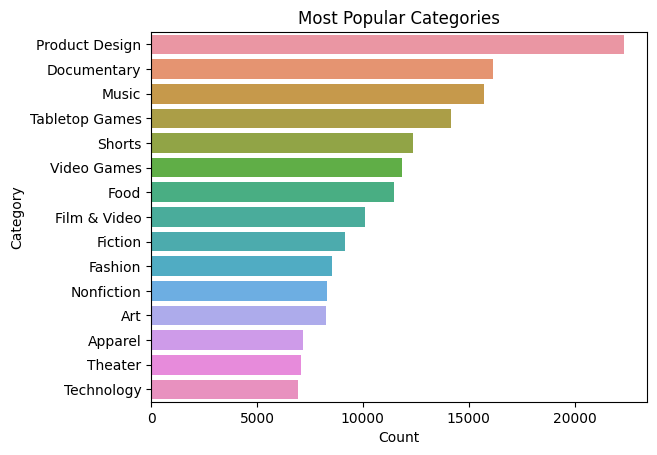

In [12]:
top_15 = sns.barplot(data=categories.iloc[0:15], x="count", y="category")
top_15.set(xlabel='Count', ylabel='Category', title='Most Popular Categories')

Similarly, lets visualise the 15 least frequent categories:

[Text(0.5, 0, 'Count'),
 Text(0, 0.5, 'Category'),
 Text(0.5, 1.0, 'Least Popular Categories')]

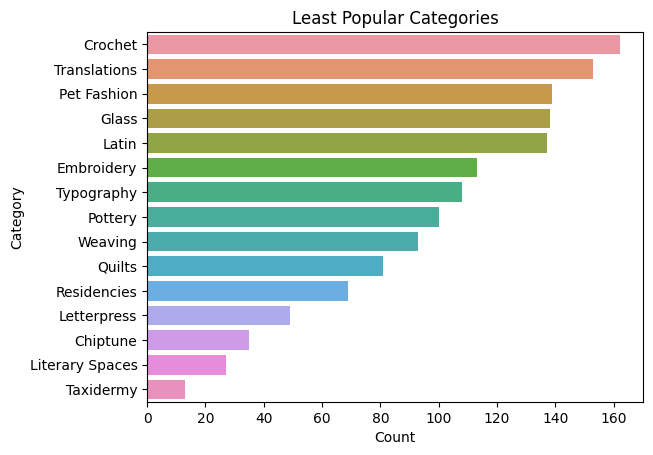

In [13]:
low_15 = sns.barplot(data=categories[-15:], x='count', y='category')
low_15.set(xlabel='Count', ylabel='Category', title='Least Popular Categories')

### Country

There are 23 unique countries in total:

In [14]:
countries = pd.read_sql(f'''
                        SELECT country, COUNT(country) AS count, 100 * (COUNT(country) * 1.0 / {total_obs}) AS percentage
                        FROM kickstarter_2018
                        GROUP BY country
                        ORDER BY COUNT(country) DESC
                        ''', conn)

len(countries)

23

A majority (roughly 77%) of kickstarter projects originate from the United States:

In [15]:
countries.iloc[0:5]

,country,count,percentage
0,US,292627,77.279414
1,GB,33672,8.892387
2,CA,14756,3.896889
3,AU,7839,2.070189
4,DE,4171,1.101513


A treemap can best illustrate this dominance:

<Axes: >

(0.0, 100.0, 0.0, 100.0)

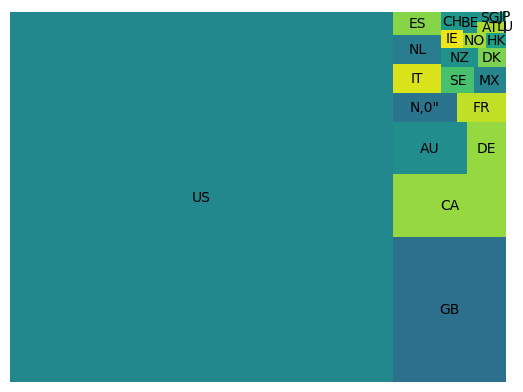

In [16]:
squarify.plot(sizes=countries['count'], label=countries['country'], alpha=1)
# Remove the axis
plt.axis('off')

### Currency

The dataset has 14 different currencies. Some countries share the same currency, such as the EUR (Euro) for many European countries. The USD (US Dollar) is the most common currency in the dataset, with 78% of the projects. This is not surprising, since the US is the most frequent country in the dataset.

In [17]:
currencies = pd.read_sql(f'''
                         SELECT currency, COUNT(currency) AS count, 100 * (COUNT(currency) * 1.0 / {total_obs}) AS percentage
                         FROM kickstarter_2018
                         GROUP BY currency
                         ORDER BY count DESC
                         ''', conn)

currencies

,currency,count,percentage
0,USD,295365,78.002488
1,GBP,34132,9.013867
2,EUR,17405,4.596460
3,CAD,14962,3.951292
4,AUD,7950,2.099503
5,SEK,1788,0.472190
6,MXN,1752,0.462683
7,NZD,1475,0.389530
8,DKK,1129,0.298156
9,CHF,768,0.202820


###  Goal, Pledged, and Backers

Next, I examine the numerical variables: goals, pledged, and backers. I use the usd_goal_real and usd_pledged_real columns which have values converted from the goal and pledged columns (respectively) into USD using fixer.io. Fixer.io is an API that provides access to current and historical foreign exchange (forex) rates. 

In [18]:
# access numeric variables
numeric_vars = pd.read_sql('''
                           SELECT name, backers, usd_goal_real, usd_pledged_real
                           FROM kickstarter_2018
                           ''', conn)

The summary statistics for all three suggests right-skewed distributions. The means for each surpasses the medians by relatively large amounts. Furthermore, the mean is also higher than the upper quartile (the 75th percentile) for each, indicating that most Kickstarter projects lie on the left, and lower, end of the distribution for each respective variable. This also suggests that there are a relatively small number of Kickstarter projects with high goals, pledges, and backers. It’s important to note that such right skewness renders the standard deviation an inaccurate measure of variation for each variable.

In [19]:
pd.options.display.float_format = '{:.2f}'.format # remove scientific notation from .describe()
numeric_vars.describe()
# pd.reset_option('display.float_format') # reset to default format

,backers,usd_goal_real,usd_pledged_real
count,378661.00,378661.00,378661.00
mean,105.62,45454.40,9058.92
std,907.19,1152950.06,90973.34
min,0.00,0.01,0.00
25%,2.00,2000.00,31.00
50%,12.00,5500.00,624.33
75%,56.00,15500.00,4050.00
max,219382.00,166361390.71,20338986.27


Visualising these three variables reinforces the interpretation of their summary statistics. The boxplots are 'squished' to the left thanks to a small number of high values. 

[Text(0.5, 0, 'Monetary Goal (US $)'),
 Text(0.5, 1.0, 'Violin Plot of Kickstarter Monetary Goal')]

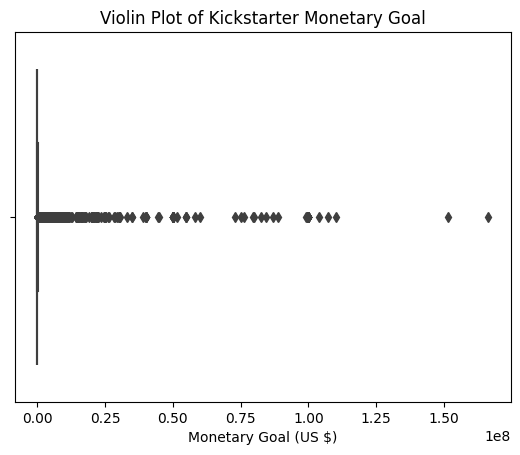

[Text(0.5, 0, 'Pledged Money (US $)'),
 Text(0.5, 1.0, 'Violen Plot of Pledged Money')]

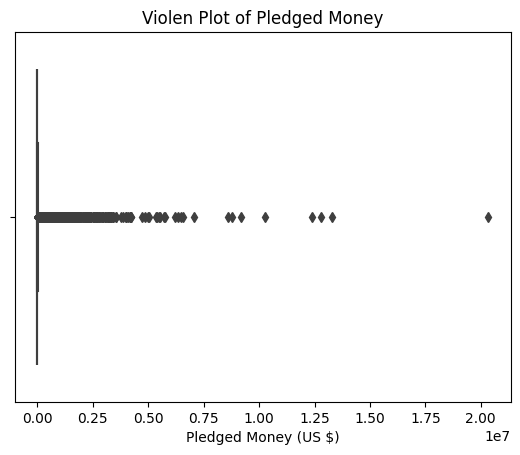

[Text(0.5, 0, 'Number of Backers'), Text(0.5, 1.0, 'Violen Plot of Backers')]

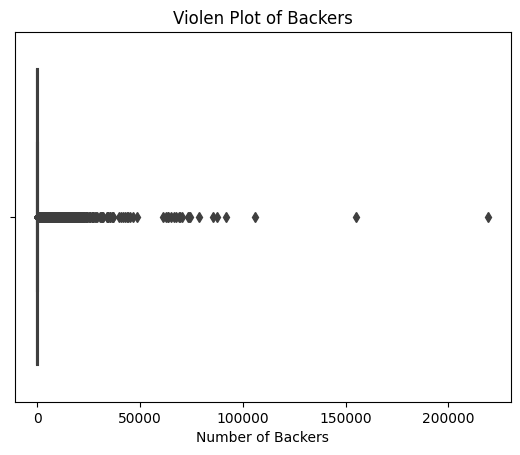

In [20]:
# goal
goal_viz = sns.boxplot(data=numeric_vars, x='usd_goal_real')
goal_viz.set(xlabel='Monetary Goal (US $)', title='Violin Plot of Kickstarter Monetary Goal')
plt.show()

# pledged
pledged_viz = sns.boxplot(data=numeric_vars, x='usd_pledged_real')
pledged_viz.set(xlabel='Pledged Money (US $)', title='Violen Plot of Pledged Money')
plt.show()

# backers
backers_viz = sns.boxplot(data=numeric_vars, x='backers')
backers_viz.set(xlabel='Number of Backers', title='Violen Plot of Backers')
plt.show()

The visualisations below replots the above graphs by excluding values higher than the variable's respective mean. This allows one a clearer look at the distribution for the majority of data for each variable. The visualisations reinforce previous interpretations, that the data is right skewed and the majority of observations are concentrated to the left of the distribution for each variable.

[Text(0.5, 0, 'Monetary Goal (US $)'),
 Text(0.5, 1.0, 'Boxplot of Kickstarter Monetary Goal')]

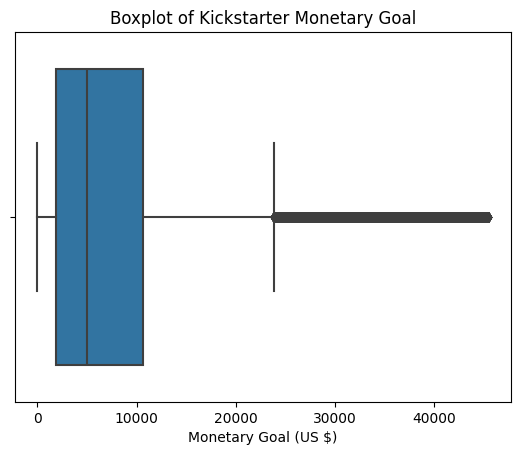

[Text(0.5, 0, 'Pledged Money (US $)'),
 Text(0.5, 1.0, 'Boxplot of Pledged Money')]

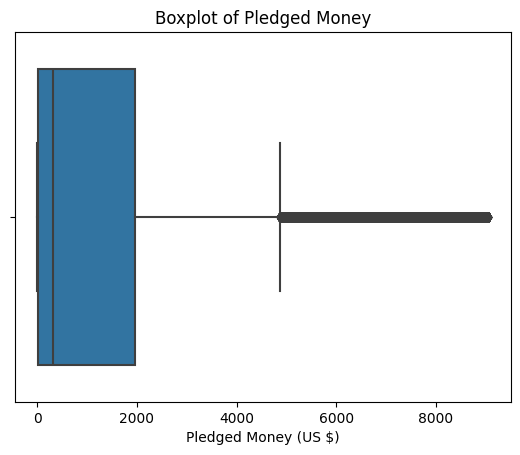

[Text(0.5, 0, 'Number of Backers'), Text(0.5, 1.0, 'Boxplot of Backers')]

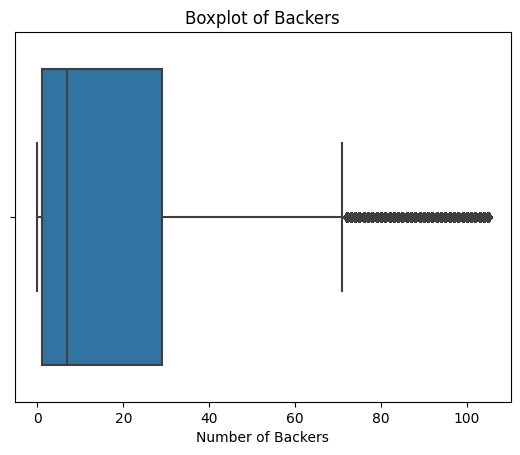

In [21]:
# goal
goal_viz = sns.boxplot(data=numeric_vars[numeric_vars['usd_goal_real'] < numeric_vars['usd_goal_real'].mean()], x='usd_goal_real')
goal_viz.set(xlabel='Monetary Goal (US $)', title='Boxplot of Kickstarter Monetary Goal')
plt.show()

# pledged
pledged_viz = sns.boxplot(data=numeric_vars[numeric_vars['usd_pledged_real'] < numeric_vars['usd_pledged_real'].mean()], x='usd_pledged_real')
pledged_viz.set(xlabel='Pledged Money (US $)', title='Boxplot of Pledged Money')
plt.show()

# backers
backers_viz = sns.boxplot(data=numeric_vars[numeric_vars['backers'] < numeric_vars['backers'].mean()], x='backers')
backers_viz.set(xlabel='Number of Backers', title='Boxplot of Backers')
plt.show()

### Launch Date and Funding Period

Another aspect worth exploring is the overall timeline of all Kickstarter projects in the dataset, as well as their funding period. The funding period refers to the duration between the launch of a project and its deadline. While the original dataset does not include a specific variable for the funding period, it does provide the relevant information to derive it: the launch date and deadline. I also create a variable that represents the year-month for each project.

In [22]:
# Extract data from database
timeline = pd.read_sql('''
                       SELECT launched, deadline
                       FROM kickstarter_2018
                       ''', conn)
# split the launched column and save only the first column (i.e., launch date) into timeline DataFrame
timeline['launch_date'] = timeline['launched'].str.split(" ", expand=True)[0]
# convert launch_date and deadline to datetime format
timeline["launch_date"] = pd.to_datetime(timeline["launch_date"], format='%Y-%m-%d')
timeline["deadline"] = pd.to_datetime(timeline["deadline"], format='%Y-%m-%d')
# create funding_period variable
timeline['funding_period'] = timeline["deadline"] - timeline["launch_date"]
timeline['funding_period'] = timeline['funding_period'].dt.days # only keep number for days
# create month-year variable
timeline["launch_yr_mth"] = timeline["launch_date"].dt.to_period("M")
# Lastly order by launch_date
timeline = timeline.sort_values(by='launch_date', ascending=True)


Using a lineplot to visualise the number of launchs per day reveals a clear error. The graph indicates possible Kickstarter projects launching as far back as 1970 which is impossible (Kickstarter began in 2009).

<Axes: xlabel='launch_date', ylabel='count'>

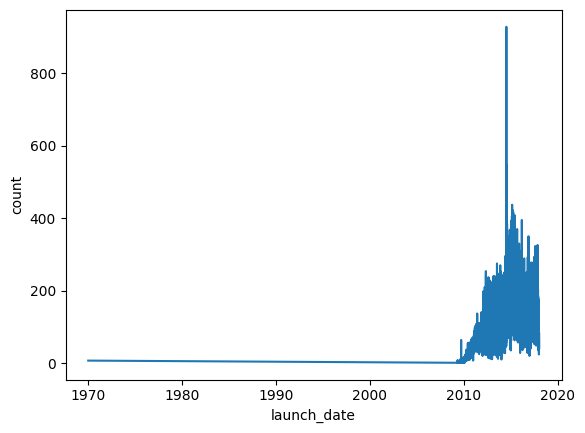

In [23]:
# calculate number of launches per day and sort in ascending
launch_date_counts = timeline["launch_date"].value_counts().to_frame().reset_index()
launch_date_counts = launch_date_counts.sort_values(by='launch_date', ascending=True)

# visualise
sns.lineplot(data=launch_date_counts, x='launch_date', y='count')

Checking the first five rows reveals 7 submissions with the launch date of 1970-01-01 which is impossible as Kickstarter began in 2009.

In [24]:
launch_date_counts.head()

,launch_date,count
2983,1970-01-01,7
3138,2009-04-21,1
3141,2009-04-23,1
3139,2009-04-24,1
3144,2009-04-25,1


For now, I'll simply exclude this first row from the visualisation.

The launches vary considerably day by day though there does appear to be an overall trend across time though it is somewhat hidden by the daily variability in counts.

[Text(0.5, 0, 'Day'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Number of launches per Day')]

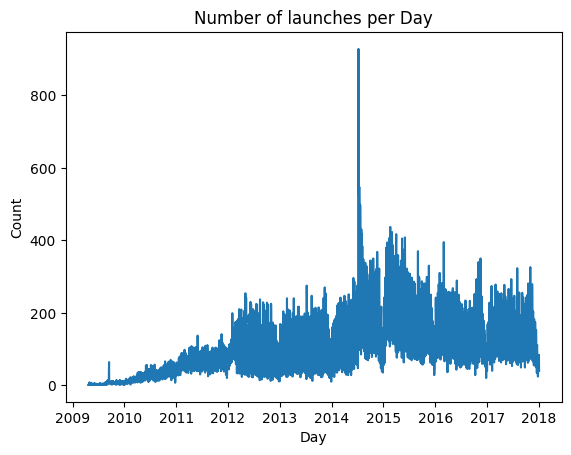

In [25]:
day_lineplot = sns.lineplot(data=launch_date_counts.iloc[1:], x="launch_date", y="count")
day_lineplot.set(xlabel='Day', ylabel='Count', title='Number of launches per Day')

The visualisation below shows the launch counts by month which makes the overall trend easier to see. Monthly launches grew steadily from 2009 to early 2015, then started to decline gradually. There is also a huge spike in launched in mid 2014. From 2013 there appears to be trend in which January sees the lowest amount of launches for the year.

[Text(0.5, 0, 'Month'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Number of launches per Month')]

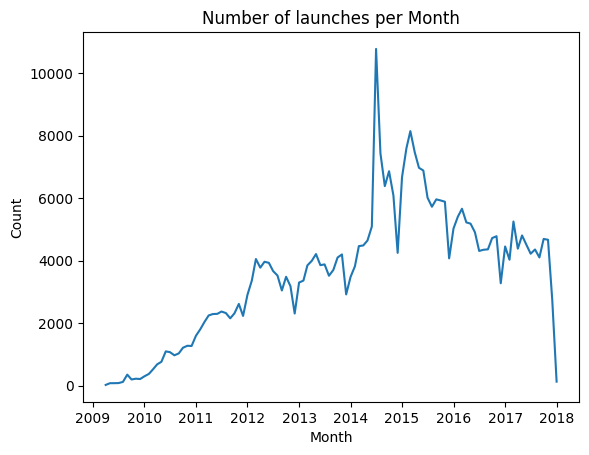

In [26]:
# number of kickstarter launches on each month
launch_mth_counts = timeline["launch_yr_mth"].value_counts().to_frame().reset_index()
launch_mth_counts = launch_mth_counts.sort_values(by="launch_yr_mth", ascending=True)
# converting the yr-mth to yr=mt=day where day = 1 as it makes the data compatible with sns.lineplot
launch_mth_counts["launch_yr_mth"] = pd.to_datetime(launch_mth_counts['launch_yr_mth'].astype(str) + '-1', format='%Y-%m-%d')

# plot
mth_lineplot = sns.lineplot(data=launch_mth_counts[1:], x='launch_yr_mth', y='count')
mth_lineplot.set(xlabel='Month', ylabel='Count', title='Number of launches per Month')

The top 15 months for launch counts are exclusively in 2014 and 2015 with July 2014 seeing the highest amount of launches at 10775.

In [27]:
launch_mth_counts.sort_values(by='count', ascending=False).head(15)

,launch_yr_mth,count
0,2014-07-01,10775
1,2015-03-01,8144
2,2015-02-01,7591
3,2015-04-01,7470
4,2014-08-01,7430
5,2015-05-01,6970
6,2015-06-01,6883
7,2014-10-01,6860
8,2015-01-01,6669
9,2014-09-01,6383


Next, I turn my attention to funding_period. The summary statistics reveal a data issue immediately, as they show a max value of 16739 days, which is impossible for two reasons. First, Kickstarter limits the funding period to 60 days, while before 2011 the limit was 90 days. Second, and more glaringly, 16739 days is roughly 45 years, which is longer than Kickstarter’s existence.

In [28]:
timeline.funding_period.describe()

count   378661.00
mean        34.48
std         65.91
min          1.00
25%         30.00
50%         30.00
75%         37.00
max      16739.00
Name: funding_period, dtype: float64

The dataset contains 496 instances where the funding_period exceeds 90 days, but only 7 instances where it surpasses 92 days. It’s unclear how stringent Kickstarter was in enforcing funding periods when they allowed durations of up to 90 days, so the values of 91 and 92 days is retained. The instances where the funding_period exceeds 92 days resulted from the inaccurately dated launches of 1970.

In [29]:
# count values
timeline[timeline['funding_period'] > 90]['funding_period'].count()
timeline[timeline['funding_period'] > 91]['funding_period'].count()
timeline[timeline['funding_period'] > 92]['funding_period'].count()

# display rows whose funding_period is over 92
timeline[timeline['funding_period'] > 92]


496

29

7

,launched,deadline,launch_date,funding_period,launch_yr_mth
273779,1970-01-01 01:00:00,2010-04-10,1970-01-01,14709,1970-01
2842,1970-01-01 01:00:00,2010-09-15,1970-01-01,14867,1970-01
319002,1970-01-01 01:00:00,2015-10-31,1970-01-01,16739,1970-01
48147,1970-01-01 01:00:00,2010-08-14,1970-01-01,14835,1970-01
75397,1970-01-01 01:00:00,2010-05-21,1970-01-01,14750,1970-01
94579,1970-01-01 01:00:00,2010-06-01,1970-01-01,14761,1970-01
247913,1970-01-01 01:00:00,2010-05-04,1970-01-01,14733,1970-01


After removing the rows with erroneous funding_period values, the summary statistics suggest a slight right skew in the data, as indicated by the mean being 4.2 higher than the median.

In [30]:
funding_period = timeline[timeline['funding_period'] < 93]
funding_period['funding_period'].describe()

count   378654.00
mean        34.20
std         12.79
min          1.00
25%         30.00
50%         30.00
75%         37.00
max         92.00
Name: funding_period, dtype: float64

Visualizing the funding_period with a violin plot reveals a distinct distribution. The majority of values are tightly clustered around 30, with the next largest proportion centering at 60. Kickstarter themselves suggest funding periods of 30 or less (stating that kickstarter projects with this period have the most success) on their website which may explain the unusual shape of this distribution as stemming from people taking Kickstarter's advice.

[Text(0.5, 1.0, 'Funding Period'), Text(0.5, 0, 'Days')]

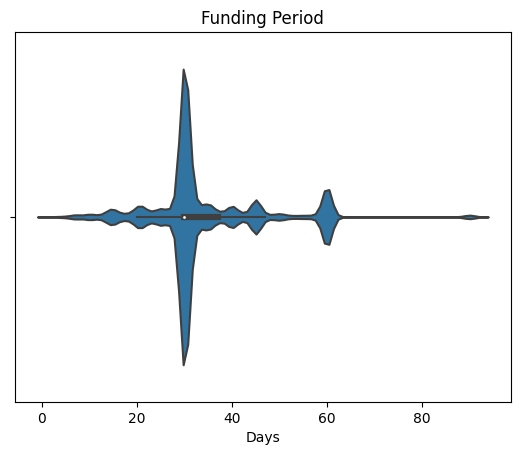

In [31]:
vio_fp = sns.violinplot(data=funding_period, x='funding_period')
vio_fp.set(title='Funding Period', xlabel='Days')

In [32]:
conn.close() # close connection

# Data Cleaning and Wrangling

Exploring the Kickstarter dataset unveiled some data errors that require cleaning and provided insights that will inform my data wrangling efforts. I will now mainly use Python and operate on a single Pandas DataFrame that is created in this section.

In [33]:
# create copy of database
conn = sqlite3.connect('sql-ks-projects-201801.db')
cur = conn.cursor()
df = pd.read_sql('SELECT * FROM kickstarter_2018', conn)
conn.close() # close connection to database

In [34]:
len(df.columns)

15

Beginning with time, I:

* Create a launch_date variable that omits the specific time of day.
* Create a funding_period variable that represents the duration a Kickstarter project had to secure backer funding.
* Create month variable due to possibility of launch month influencing Kickstarter success.
* Remove the seven rows with incorrect launch_date years set 1970. 

In [35]:
# splits the launched column and saves only the first column (i.e., launch date) into df DataFrame
df['launch_date'] = df['launched'].str.split(' ', expand=True)[0]
# convert launch_date and deadline to datetime format
df['launch_date'] = pd.to_datetime(df['launch_date'], format='%Y-%m-%d')
df['deadline'] = pd.to_datetime(df['deadline'], format='%Y-%m-%d')
# Calculate the funding period (new variable)
df['funding_period'] = df['deadline'] - df['launch_date']
df['funding_period'] = df['funding_period'].dt.days # convert to numeric
# obtain month launched 
df['month'] = df['launch_date'].dt.strftime('%B')
# remove rows whose launch date is incorrect
df = df[df['launch_date'] > '2009-01-01']

State is our outcome of interest so deserves some special attention. I conduct four actions:

* Remove 'live' as it is unknown whether the kickstarter succeeded or failed.
* Remove 'suspended' as this failure was not necessary due to lack of pledges.
* Remove 'canceled' as it is unclear why the kickstarter was canceled, it could be due to something entirely unrelated to pledges.
* Determine the true value of 'undefined'. if usd_pledged_real is equal to or greater than usd_goal_real, then the kickstarter can be assumed to have succeeded (as the pledge amount has met their goal).

In [36]:
# remove rows whose state variable is live, undefined, or suspended
ste_val_remove = ['live', 'suspended', 'canceled']
df = df[df['state'].isin(ste_val_remove) == False]

# check if kickstarters termed undefined were actually successful
df[(df['usd_pledged_real'] >= df['usd_goal_real']) & (df['state'] == 'undefined')]['state'].count() # 1654
# update state value to successful if pledges met the goal
df.loc[(df['usd_pledged_real'] >= df['usd_goal_real']) & (df['state'] == 'undefined'), 'state'] = 'successful'
# update state value to failed if pledges did not meet the goal
df.loc[(df['usd_pledged_real'] < df['usd_goal_real']) & (df['state'] == 'undefined'), 'state'] = 'failed'

# state is now a binary variable
df['state'].unique() 

1654

array(['failed', 'successful'], dtype=object)

For country, I:

* Remove rows containing the incorrect value of 'N,0'. I examined a small sample of the Kickstarter projects with the country value 'N,0' on the Kickstarter website and discovered they originated from different countries which indicates against a the possibility of a simple misentry for NO (Norway). As it is unclear which country these rows belong to, and manually identifying 3766 rows as a lone individual would be too time consuming, I removed these rows from the dataset.
* Create a new column that contains the full country names for simple ease of interpretation. 
* Create a new variable that groups the countries together regionally, in North America, Europe, and Other.


In [37]:
# Drop rows containing 'N,0"'
df.drop(df[df['country'] == 'N,0"'].index, inplace=True)


# Convert acronym to country names
country_dict = {
    'GB': 'United Kingdom', 'US': 'United States', 'CA': 'Canada', 'AU': 'Australia',
    'NO': 'Norway', 'IT': 'Italy', 'DE': 'Germany', 'IE': 'Ireland', 'MX': 'Mexico',
    'ES': 'Spain', 'SE': 'Sweden', 'FR': 'France', 'NZ': 'New Zealand', 'CH': 'Switzerland',
    'AT': 'Austria', 'BE': 'Belgium', 'DK': 'Denmark', 'HK': 'Hong Kong', 'NL': 'Netherlands',
    'LU': 'Luxembourg', 'SG': 'Singapore', 'JP': 'Japan'
}

# Convert acronym to regions
regional_dict = {
    'GB': 'Europe', 'US': 'North America', 'CA': 'North America', 'AU': 'Other',
    'NO': 'Europe', 'IT': 'Europe', 'DE': 'Europe', 'IE': 'Europe', 'MX': 'Other',
    'ES': 'Europe', 'SE': 'Europe', 'FR': 'Europe', 'NZ': 'Other', 'CH': 'Europe',
    'AT': 'Europe', 'BE': 'Europe', 'DK': 'Europe', 'HK': 'Other', 'NL': 'Europe',
    'LU': 'Europe', 'SG': 'Other', 'JP': 'Other'
}

# create variables
df['country_name'] = df['country'].replace(country_dict)
df['region'] = df['country'].replace(regional_dict)

print(f'The dataset now contains {len(df)} rows.')

The dataset now contains 331465 rows.


Finally, I drop columns for a few reasons:

* Certain columns, such as country and goal, I deemed unnecessary as alternative variables represent their information.

* I removed the backers column and the pledged columns as they contain information that wouldn’t be available when trying to predict the success of a new Kickstarter project before its launch and end of funding period. For instance, the number of pledges or the number of backers a project will receive is unknowable until the funding period concludes, and when the funding period concludes one will know whether the Kickstarter project was a success or failure.

* I removed the date columns (deadline, launched, launch_date) as logically, new projects are independent of the success of past projects. However, I maintain the month variable to capture any potential seasonal trends in Kickstarter success.

In [38]:
# drop unneeded columns
df.drop(['pledged', 'usd pledged', 'usd_pledged_real', 'backers', 'goal', 'deadline', 'launched', 'launch_date' ,'country', 'usd_pledged_real'], axis=1, inplace=True)

# Bivariate Analysis

In this section, I identify and quantify the associations between Kickstarter project success (represented by the 'state' variable) and the other predictor variables in the dataset. Variables that demonstrate evidence of a clear association will be included in the model to help predict kickstarter project success and failure.

### Create training and test sets

In preparation for later assessing my model's performance, I take a machine learning approach by splitting my dataset into training and testing sets. I split the data into an 80-20 ratio for the training and testing sets respectively. Setting the random_state parameter to 42 ensures that the same data split will be reproduced in multiple runs of the code as long as its value remains 42. This allows others to reproduce this analysis.

In [39]:
# separate outcome of interest (state) from the predictor variables
y_data = df['state']
x_data = df.drop('state', axis=1)

# create training and testing sets, using a 80 | 20 split
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.20, random_state=42)


In this context, performance is defined as the model's ability to predict unseen values. The training set is designated for exploring associations and constructing the model, while the testing set is exclusively reserved for evaluating the model's performance. Since the testing set is used only for this evaluation purpose and not for exploring associations or the model-building process, it serves as a source of unseen values for the model.

## Categoric Variables

I explore the possible associations between the outcome of interest (state) and the categorical predictor variables in two ways. First, I visually examine the association with percent bar plots or a table if it suffices. Second I quantify the association with chi-square test of independence hypothesis tests. For all the chi-square tests the null hypothesis is that the state and categoric predictor is independent, in other words, that there is no significant association between the two within the dataset.

### Main Category

A percent stacked bar plot shows that the proportion of failed and successful projects differ by main_category which indicates a possible association between main_category and state. If there was no association, then the majority of the bars should show a similar percentage of failed and successful kickstarter projects.

Text(0, 0.5, 'Percentage')

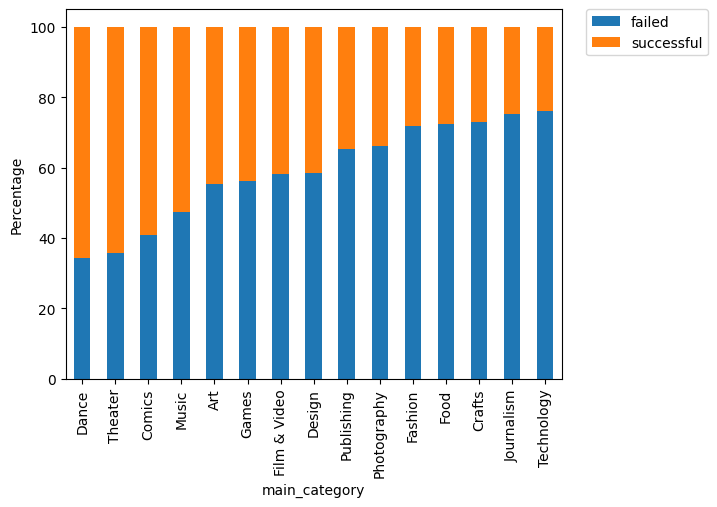

In [40]:
# cross tab
cross_tab_viz = pd.crosstab(x_train['main_category'], y_train, )
# calculate percentages
cross_tab_viz['failed'] = (cross_tab_viz['failed'] / (cross_tab_viz['failed'] + cross_tab_viz['successful'])) * 100
cross_tab_viz['successful'] = 100 - cross_tab_viz['failed']
# plot
ax = cross_tab_viz.sort_values('failed').plot(kind='bar', stacked=True)
plt.ylabel('Percentage')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0) # stop legend blocking graph

A chi-square test showed a significant association between the two variables, with p < 0.05. Therefore, I reject the null hypothesis and conclude that the state and the main_category are not independent. Based on the chi-square test and the percent stacked bar plot, there is reasonable evidence to suggest an association between state and main_category.

In [41]:
# Create crosstabulation table
cross_tab = pd.crosstab(y_train, x_train['main_category'])

# run chi-square
chi = scipy.stats.chi2_contingency(cross_tab, correction=True)
print("Chi-square statistics:", chi.statistic)
print("p-value:", chi.pvalue)
print("Degrees of freedom:", chi.dof)

Chi-square statistics: 12411.987455194118
p-value: 0.0
Degrees of freedom: 14


### Category

Displaying 159 category labels on the x-axis is not practical. Therefore, the percent bar plot below does not include labels, but each category is still represented by a bar as usual. Similar to the main_category, the percent bar plot suggests an association between category and state, as different categories exhibit varying percentages of success and failure.

Text(0, 0.5, 'Percentage')

[]

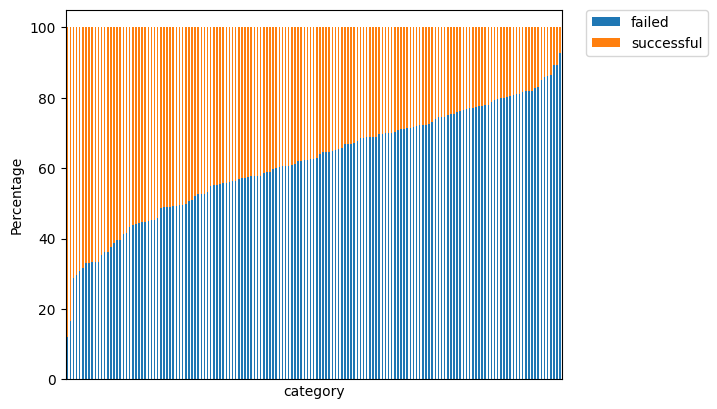

In [42]:
# cross tab
cross_tab_viz = pd.crosstab(x_train['category'], y_train, )
# calculate percentages
cross_tab_viz['failed'] = (cross_tab_viz['failed'] / (cross_tab_viz['failed'] + cross_tab_viz['successful'])) * 100
cross_tab_viz['successful'] = 100 - cross_tab_viz['failed']
# plot
ax = cross_tab_viz.sort_values('failed').plot(kind='bar', stacked=True)
plt.ylabel('Percentage')
ax.set_xticks([])
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0) # stop legend blocking graph

A chi-square test showed a significant association between the two variables, with p < 0.05. Therefore, I reject the null hypothesis and conclude that the state and category are not independent. Based on the chi-square test and the percent stacked bar plot, there is reasonable evidence to suggest an association between state and category.

In [43]:
# Create crosstabulation table
cross_tab = pd.crosstab(y_train, x_train['category'])

# run chi-square
chi = scipy.stats.chi2_contingency(cross_tab, correction=True)
print("Chi-square statistics:", chi.statistic)
print("p-value:", chi.pvalue)
print("Degrees of freedom:", chi.dof)

Chi-square statistics: 25274.060507295853
p-value: 0.0
Degrees of freedom: 158


### Region and Country

Failure was the most common outcome in all regions. North America shows the highest percentage of success, followed by Europe, and then lastly the Other Category.

In [44]:
cross_tab_viz = pd.crosstab(x_train['region'], y_train, )
# calculate percentages
cross_tab_viz['failed'] = (cross_tab_viz['failed'] / (cross_tab_viz['failed'] + cross_tab_viz['successful'])) * 100
cross_tab_viz['successful'] = 100 - cross_tab_viz['failed']

cross_tab_viz

state,failed,successful
region,,
Europe,63.83,36.17
North America,58.54,41.46
Other,68.31,31.69


A chi-square test showed a significant association between the two variables, with p < 0.05. Therefore, I reject the null hypothesis and conclude that the state and region are not independent. Based on the chi-square test and the percentages shown in the table, there is reasonable evidence to suggest an association between state and region.

In [45]:
# create cross tab table
cross_tab = pd.crosstab(x_train['region'], y_train, )
# chi-square test
chi = scipy.stats.chi2_contingency(cross_tab, correction=True)
print("Chi-square statistics:", chi.statistic)
print("p-value:", chi.pvalue)
print("Degrees of freedom:", chi.dof)

Chi-square statistics: 643.4065753540885
p-value: 1.9321344841134257e-140
Degrees of freedom: 2


Regarding country_name, failure is the most common outcome regardless of country with not one country showing a success percentage that was over 50%. There does however appear to be clear differences in success between countries. For example, near 80% of kickstarter projects failed in Italy and Austria, while Hong Kong, United States, and United Kingdom have under 60% failure. 

Text(0, 0.5, 'Percentage')

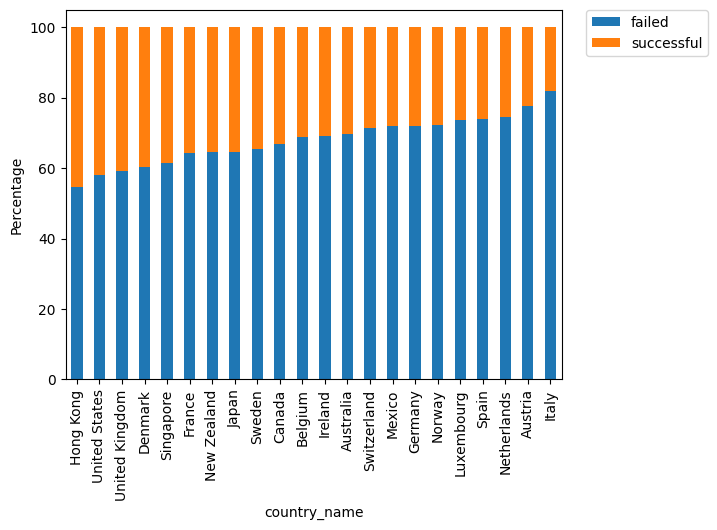

In [46]:
# create cross tab table
cross_tab_viz = pd.crosstab(x_train['country_name'], y_train)

# calculate percentages
cross_tab_viz['failed'] = (cross_tab_viz['failed'] / (cross_tab_viz['failed'] + cross_tab_viz['successful'])) * 100
cross_tab_viz['successful'] = 100 - cross_tab_viz['failed']

# plot
ax = cross_tab_viz.sort_values('failed').plot(kind='bar', stacked=True)
plt.ylabel('Percentage')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0) # stop legend blocking graph

A chi-square test showed a significant association between the two variables, with p < 0.05. Therefore, I reject the null hypothesis and conclude that the state (representing Kickstarter project success) and country_name are not independent. Based on the chi-square test and the percent stacked bar plot, there is reasonable evidence to suggest an association between state and country_name.

In [47]:
# create cross-tab
cross_tab = pd.crosstab(x_train['country_name'], y_train)
chi = scipy.stats.chi2_contingency(cross_tab, correction=True)
# chi-square test
print("Chi-square statistics:", chi.statistic)
print("p-value:", chi.pvalue)
print("Degrees of freedom:", chi.dof)

Chi-square statistics: 1772.4947848168022
p-value: 0.0
Degrees of freedom: 21


### Currency

The percent stacked bar plot shows differences between failure and success rate by currency. The failure rate ranges between 54.71% and 72.90%. The EUR, NOK, and MXN currencies show success rates under 30%. On the other hand, the HKD, USD, and GBP currencies have success rates above 40%.

Text(0, 0.5, 'Percentage')

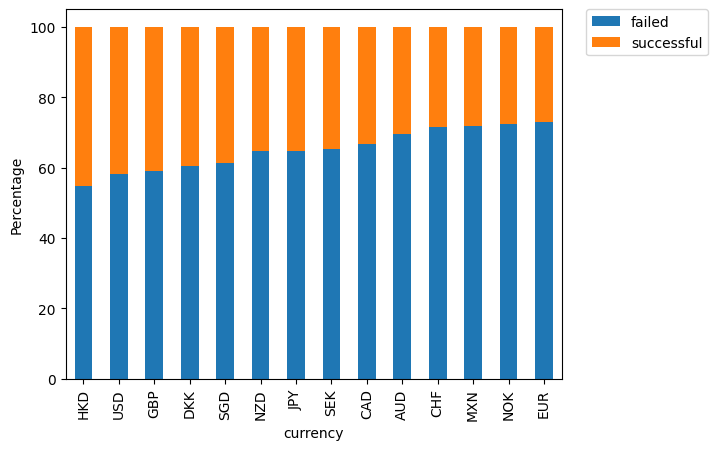

In [48]:
# create cross-tab
cross_tab_viz = pd.crosstab(x_train['currency'], y_train)
# calculate percentages
cross_tab_viz['failed'] = (cross_tab_viz['failed'] / (cross_tab_viz['failed'] + cross_tab_viz['successful'])) * 100
cross_tab_viz['successful'] = 100 - cross_tab_viz['failed']

# plot
ax = cross_tab_viz.sort_values('failed').plot(kind='bar', stacked=True)
plt.ylabel('Percentage')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0) # stop legend blocking graph

A chi-square test showed a significant association between the two variables, with p < 0.05. Therefore, I reject the null hypothesis and conclude that the state and currency are not independent. Based on the chi-square test and the percent stacked bar plot, there is reasonable evidence to suggest an association between state and currency.

In [49]:
# create cross-tabl
cross_tab = pd.crosstab(x_train['currency'], y_train)
chi = scipy.stats.chi2_contingency(cross_tab, correction=True)
#chi-square test
print("Chi-square statistics:", chi.statistic)
print("p-value:", chi.pvalue)
print("Degrees of freedom:", chi.dof)

Chi-square statistics: 1634.7041154878846
p-value: 0.0
Degrees of freedom: 13


### Month

The percent bar plot reveals a relatively minor variation in success percentages, with a small difference of approximately 5% between the lowest (July) and highest (April) success percentages.

Text(0, 0.5, 'Percentage')

state,failed,successful
month,,
April,57.56,42.44
March,57.60,42.40
October,58.09,41.91
February,58.10,41.90
May,58.57,41.43
November,58.63,41.37
September,58.90,41.10
June,59.22,40.78
January,61.08,38.92


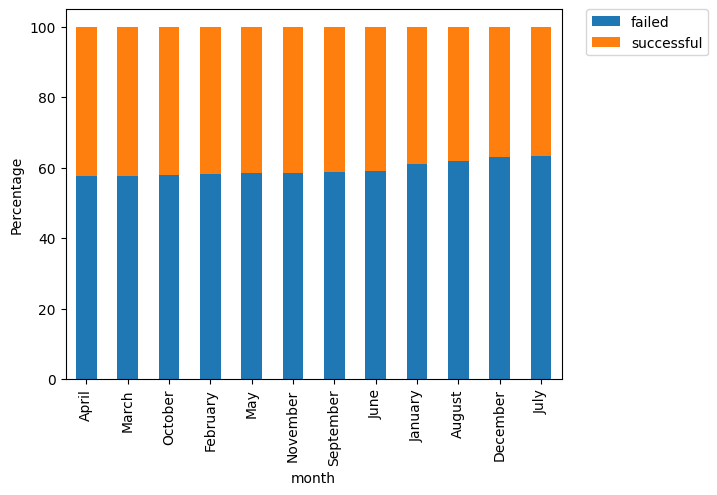

In [50]:
cross_tab_viz = pd.crosstab(x_train['month'], y_train)
# calculate percentages
cross_tab_viz['failed'] = (cross_tab_viz['failed'] / (cross_tab_viz['failed'] + cross_tab_viz['successful'])) * 100
cross_tab_viz['successful'] = 100 - cross_tab_viz['failed']

# plot
ax = cross_tab_viz.sort_values('failed').plot(kind='bar', stacked=True)
plt.ylabel('Percentage')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0) # stop legend blocking graph

# table
cross_tab_viz.sort_values('failed')

In [51]:
# create cross-tabl
cross_tab = pd.crosstab(x_train['month'], y_train)
chi = scipy.stats.chi2_contingency(cross_tab, correction=True)
#chi-square test
print("Chi-square statistics:", chi.statistic)
print("p-value:", chi.pvalue)
print("Degrees of freedom:", chi.dof)

Chi-square statistics: 443.38046606810184
p-value: 3.6899720695886273e-88
Degrees of freedom: 11


While the visualisation shows minimal variation, a chi-square test did indicate a significant association between the two variables, with p < 0.05. Therefore, I reject the null hypothesis and conclude that the state and month are not independent. Based on the conflicting evidence I will experiment with adding and removing the month variable from the model.

## Quantitative variables

There are only two quantitative variables to analyse, usd_goal_real and funding_period, which I group together with state in a new DataFrame. I also create a small function to calculate the mean and median of a quantitative variable for both the failed and successful groups (i.e., the values for state).

In [52]:
# concatenate quantitative variables with state
df_quant_train = pd.concat([y_train, x_train[['usd_goal_real', 'funding_period']]], axis=1)

# averages function
def averages(dataframe, x_var, y_var):

    failed_mean = dataframe.loc[dataframe[x_var] == 'failed'][y_var].mean()
    success_mean = dataframe.loc[dataframe[x_var] == 'successful'][y_var].mean()
    failed_median = dataframe.loc[dataframe[x_var] == 'failed'][y_var].median()
    success_median = dataframe.loc[dataframe[x_var] == 'successful'][y_var].median()

    # Calculate and display average statistics 
    print(f'Failed Mean:    {round(failed_mean, 2)}')  
    print(f'Success Mean:   {round(success_mean, 2)}')

    print(f'Failed Median:  {round(failed_median, 2)}')
    print(f'Success Median: {round(success_median, 2)}')

    return

### usd_goal_real

Successful kickstarters had, on average, a lower set goal than the failed kickstarters. This was true for both the mean and median. Due to the right skewness of usd_goal_real, the median is a a better estimate of the typical goal amount. There is a median difference of 3685.65 difference between the failed and successful groups.

In [53]:
averages(df_quant_train, 'state', 'usd_goal_real')

Failed Mean:    65480.38
Success Mean:   9524.73
Failed Median:  7500.0
Success Median: 3814.35


Due to the prevalence of some extremely high values, visualising all the goal data makes visual interpretation difficult. However, the boxplot does reveal that the failed category has far more higher extreme values than the successful category which is in keeping with the idea that Kickstarter projects with lower goals tend to succeed more than those with higher goals.

<Axes: xlabel='usd_goal_real', ylabel='state'>

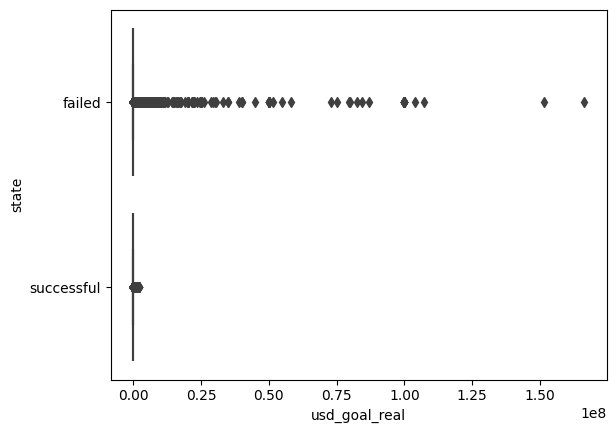

In [54]:
sns.boxplot(data=df_quant_train, x='usd_goal_real', y='state')

I exclude higher goal values to provide a clearer view of the distribution for the majority of kickstarter projects. Again, Kickstarter projects in the successful category tended to have lower goal amounts than the failed category.

<Axes: xlabel='usd_goal_real', ylabel='state'>

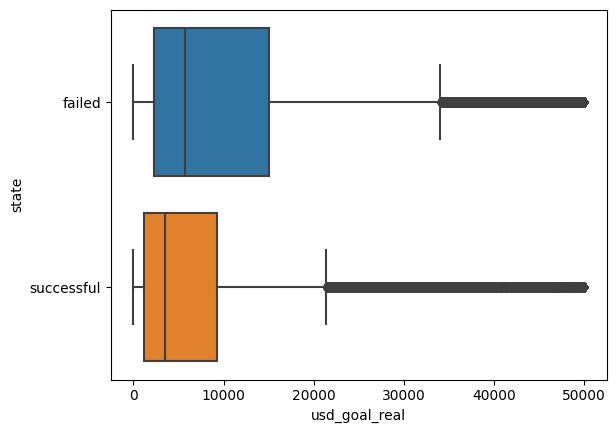

In [55]:
sns.boxplot(data=df_quant_train[df_quant_train['usd_goal_real'] <= 50000], x='usd_goal_real', y='state')

As the data is highly skewed to the right and not normally distributed, I use the non-parametric test Wilcoxon-Mann Whitney test to compare the goal amount (usd_goal_real) between the successful and failed groups of the state variable. The null hypothesis is that there is no significant difference in the distribution between the successful and failed groups. As p < 0.05, I reject the null hypothesis and conclude that there is significant difference between the two groups.

In [56]:
failed = df_quant_train[df_quant_train['state'] == 'failed']['usd_goal_real']
succesful = df_quant_train[df_quant_train['state'] == 'successful']['usd_goal_real']

scipy.stats.mannwhitneyu(x=failed, y=succesful)

MannwhitneyuResult(statistic=10689028116.5, pvalue=0.0)

Overall, considering the large difference in median values between the two groups, the visualisations, and Wilcoxon-Mann Whitney test result, there is reasonable evidence to conclude that goal amount is associated with kickstarter project success.

### Funding Period

There is a slight mean difference in funding period where failed kickstarters had a slightly longer period on average (roughly 3 days) while the median for both are identical.

In [57]:
averages(df_quant_train, 'state', 'funding_period')

Failed Mean:    35.19
Success Mean:   32.17
Failed Median:  30.0
Success Median: 30.0


However, visualising funding period with a boxplot reveals distinct differences in the distribution of its values that is hidden away if just considering averages. For successful Kickstarter campaigns, the interquartile range (IQR) spans a range of 4, from 30 to 34. In contrast, for failed Kickstarter campaigns, the IQR is broader, spanning a range of 10, from 30 to 40. Likewise, the range between the upper and lower whiskers is noticeably smaller for the successful group than the failed group.

In [58]:
df_quant_train[(df_quant_train['state'] == 'successful')]['funding_period'].describe()

count   107135.00
mean        32.17
std         11.77
min          1.00
25%         30.00
50%         30.00
75%         34.00
max         92.00
Name: funding_period, dtype: float64

<Axes: xlabel='funding_period', ylabel='state'>

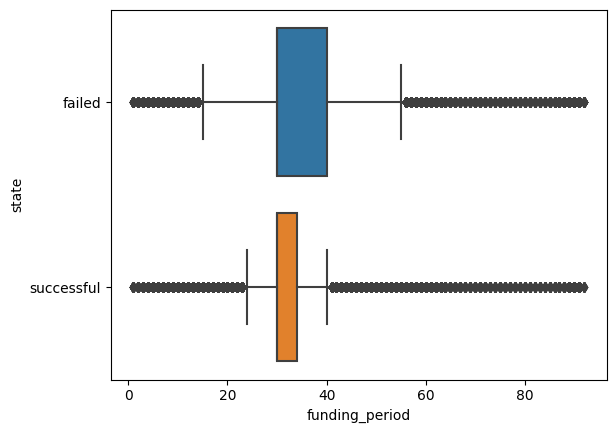

In [59]:
sns.boxplot(data=df_quant_train, x='funding_period', y='state')


As the funding_period variable demonstrates some right skewness and departure from a normal distribution, I again use the non-parametric test Wilcoxon-Mann Whitney test to compare the funding period (funding_period) between the successful and failed groups of the state variable. As p < 0.05 I reject the null hypothesis that there is no significant difference between the groups. 

In [60]:
failed = df_quant_train[df_quant_train['state'] == 'failed']['funding_period']
succesful = df_quant_train[df_quant_train['state'] == 'successful']['funding_period']

scipy.stats.mannwhitneyu(failed, succesful)
scipy.stats.ttest_ind(failed, succesful)

MannwhitneyuResult(statistic=9373684940.5, pvalue=0.0)

TtestResult(statistic=60.39795946744752, pvalue=0.0, df=265170.0)

While the median and mean differences between the two groups for funding period are neglible, the boxplot visualisation highlighted clear differences in their distribution and the Wilcoxon-Mann Whitney test indicated a significant difference. Therefore, there is reasonable evidence to conclude that funding period is associated with Kickstarter success.

# Model Building

My goal is to select and create a model for predicting whether a kickstarter project will succeed or fail and to also evaluate this model's effectiveness. An appropriate classification model for this situation is a logistic regression model which can estimate the probability of a binary outcome (like state) based on other predictor variables. 

However, logistic regression does require all variables to be numeric which necessitates encoding the several categorical predictor variables. First I create backups of the training and testing sets and drop unneeded columns:

In [61]:
x_train_model = x_train.drop(columns= ['ID', 'name'])
y_train_model = y_train[:]
x_test_model = x_test[:].drop(columns= ['ID', 'name'])
y_test_model = y_test[:]

First I encode the state variable in the training. Successful kickstarter projects are represented by 1 and failed projects by 0. The logistic model will treat 0 as the negative outcome and 1 as the positive.

In [62]:
y_train_model[y_train_model == 'successful'] = 1
y_train_model[y_train_model == 'failed'] = 0
y_train_model = y_train_model.astype(int) # must be int

The four nominal categoric variables are encoded using pandas get_dummies methods which creates a dummy variable for each value of each categoric variable in a pandas DataFrame. 

In [63]:
x_train_model = pd.get_dummies(x_train_model)

### Training

To evaluate the model accuracy, three metrics are used:

* Accuracy: Overall, how often is the logistic model correct. In other words, it is the total correctly predicted negative and correctly predicted positive divided by the total amount of obserations
* Sensitivity: When value is actually positive, how often the logistic model predicts positive
* Specificity: When value is negative, how often the logistic model predicts negative

Need a function to calculate the sensitivity and specificity of the mode:

In [64]:
# import the confusion_matrix function
from sklearn.metrics import confusion_matrix

# define a function to calculate sensitivity and specificity
def specificity_sensitivity(y_true, y_pred):
  # confusion_matrix function gets TN, FP, FN, and TP
  tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
  # calculate the specificity
  specificity = tn / (tn + fp)
  # calculate sensitivity
  sensitivity = tp / (fn + tp)

  return specificity, sensitivity

The logistic model uses all the predictor variables of x_train_model as all did indicate evidence of an association with state.

In [65]:
# Build logistic model object
logreg = LogisticRegression(random_state=6)

# fit the the model
logreg.fit(x_train_model, y_train_model)

LogisticRegression(random_state=6)

The model’s accuracy is 0.64 (rounded up), which means that it predicted the right outcome (success or failure) for roughly 64% of the cases. The model has a fairly high specificity of 0.84, which means that it identified a reasonable amount of kickstarter failures correctly. However, the model has a very low sensitivity of 0.33, which means that it failed to predict many of the kickstarter successes.

In [66]:
# use the predict method to get the predicted class labels for x_train_model
y_train_model_pred = logreg.predict(x_train_model)

# use the specificity function to get the specificity of the predictions for x_test_model
train_specificity, train_sensitivity = specificity_sensitivity(y_train_model, y_train_model_pred)

# use the score method to get the accuracy of the predictions for x_train_model
train_accuracy = logreg.score(x_train_model, y_train_model)

# print the evaluation metrics
print(f"Accuracy:    {train_accuracy:.3f}")
print(f"Specificity: {train_specificity:.3f}")
print(f"Sensitivity: {train_sensitivity:.3f}")

Accuracy:    0.635
Specificity: 0.840
Sensitivity: 0.333


In an attempt to improve the model, I conduct some feature engineering:

* Drop the first column from each dummy variable which is known to help deal with multi-collinearity issues associated with dummy variables (multicollinearity can affect logistic model's performance).
* Log transform the usd_goals_real variable. As shown in earlier analysis this variable it has many outliers and is extremely right skewed which can negatively impact a model's performance.
* Create a new binary feature that indicates whether a country is United States or not and use it to replace country_name.
* I also exclude the month variable as its removal improved the overall accuracy of the model.

In [67]:
# feature engineering for second model 
x_train_model_2 = x_train.drop(columns= ['ID', 'name'])
x_train_model_2['usa'] = np.where(x_train_model_2['country_name'] == 'United States', 1, 0) # indicator for United States
x_train_model_2.drop('country_name', inplace=True, axis=1) # Remove country variable
x_train_model_2 = pd.get_dummies(x_train_model_2, drop_first=True) # First column of dummies now removed
x_train_model_2['usd_goal_real'] = np.log(x_train_model_2['usd_goal_real']) # Log transform goal

Fit the second logistic model

In [68]:
# Build logistic model object
logreg_2 = LogisticRegression(random_state=6, max_iter=3000)

# fit the the model
logreg_2.fit(x_train_model_2, y_train_model)

LogisticRegression(max_iter=3000, random_state=6)

The second model is an improvement in several ways. Firstly, its accuracy is higher (0.67 compared to 0.64) and second, its sensitivity is fairly higher (0.48 compared to 0.33). There is a slight decrease in specificity (0.80 from 0.82). 

In [69]:
# use the predict method to get the predicted class labels for x_train_model_2
y_train_model_pred_2 = logreg_2.predict(x_train_model_2)

# use the specificity function to get the specificity of the predictions for x_train_model_2
train_specificity_2, train_sensitivity_2 = specificity_sensitivity(y_train_model, y_train_model_pred_2)
# use the score method to get the accuracy of the predictions for x_train_model_2
train_accuracy_2 = logreg_2.score(x_train_model_2, y_train_model)

# print the evaluation metrics
print(f"Accuracy:    {train_accuracy_2:.3f}")
print(f"Specificity: {train_specificity_2:.3f}")
print(f"Sensitivity: {train_sensitivity_2:.3f}")



Accuracy:    0.673
Specificity: 0.802
Sensitivity: 0.482


As mentioned earlier, the bivariate analysis of month and kickstarter success indicated conflicting evidence for an association. Removing the month variable showed little to no change for accuracy and specificity while it lowered sensitivity by 0.9 (0.479 to 0.470). 

In [70]:
# Build logistic model object
logreg_2_exl_mth = LogisticRegression(random_state=6, max_iter=3000)

# use same data as used in second log model but excluding the month dummy variables
x_train_excl_month = x_train_model_2.loc[:, ~x_train_model_2.columns.str.startswith('month')]

# fit the the model
logreg_2_exl_mth.fit(x_train_excl_month, y_train_model)

# use the predict method to get the predicted class labels for x_train_model
y_train_model_pred_excl_mth = logreg_2_exl_mth.predict(x_train_excl_month)

# use the specificity function to get the specificity of the predictions for x_test_model
train_specificity, train_sensitivity = specificity_sensitivity(y_train_model, y_train_model_pred_excl_mth)

# use the score method to get the accuracy of the predictions for x_train_model
train_accuracy = logreg_2_exl_mth.score(x_train_excl_month, y_train_model)

# print the evaluation metrics
print(f"Accuracy:    {train_accuracy:.3f}")
print(f"Specificity: {train_specificity:.3f}")
print(f"Sensitivity: {train_sensitivity:.3f}")

LogisticRegression(max_iter=3000, random_state=6)

Accuracy:    0.672
Specificity: 0.801
Sensitivity: 0.482


### Testing

The second model shows improvement in accuracy and sensitivity at the cost of a minor decrease in specificity. Therefore, I use the second model on the testing data (with the month variable excluded). First I encode and transform the test data to reflect the changes made to the training data.

In [71]:
# encodes test outcome
y_test_model[y_test_model == 'successful'] = 1
y_test_model[y_test_model == 'failed'] = 0
y_test_model = y_test_model.astype(int)

# feature engineering and encoding of testing data predictors
x_test_model['usa'] = np.where(x_test_model['country_name'] == 'United States', 1, 0) # indicator for United States
x_test_model.drop('country_name', inplace=True, axis=1) # Remove country variable
x_test_model.drop('month', inplace=True, axis=1) # Remove month variable
x_test_model = pd.get_dummies(x_test_model, drop_first=True) # First column of dummies now removed
x_test_model['usd_goal_real'] = np.log(x_test_model['usd_goal_real']) # Log transform goal

The model performed similarly on the test set as on the training set. It had an accuracy of 0.67, which means that it predicted the right outcome (success or failure) for 67% of the cases. It also maintained a high specificity of 0.80 which means that it correctly predicted 80% of the kickstarter failures. However, the model had a low sensitivity of 0.479, which means that it only correctly identified roughly 48% of the kickstarter project successes.

In [72]:
# predict y values with logreg_2 logistic model using the variable's data in the test set
y_test_pred = logreg_2_exl_mth.predict(x_test_model)


accuracy_test = logreg_2_exl_mth.score(x_test_model, y_test_model)
specificity_test, sensitivity_test = specificity_sensitivity(y_test_model, y_test_pred)

# print the evaluation metrics
print(f"Accuracy:    {accuracy_test:.3f}")
print(f"Specificity: {specificity_test:.3f}")
print(f"Sensitivity: {sensitivity_test:.3f}")

Accuracy:    0.671
Specificity: 0.801
Sensitivity: 0.479


# Conclusion

In this notebook I have explored and analysed data from the kickstarter dataset. Furthermore, I fitted an appropriate classification model (logistic regression) on the data in an attempt to predict kickstarter project succcess and failure. 

I evaluated the performance of this model using the metrics of accuracy, specificity, and sensitivity. The evaluation metrics showed the model was reasonably good at predicting kickstarter failures (a specificity of 0.80) but ineffective at predicting kickstarter successes (a low sensitivity of 0.478). The low sensitivity contributed to an overall relatively low model accuracy (0.67). 

For future work involving this data and analysis, I suggest two main areas of improvement. First, to collect more data and features that can possibly help explain kickstarter project success. The dataset lacks any variables that measure the quality of the kickstarter project's team and strategy such as size, experience, education, and whether they employed any marketing or advertisement to attract backers and pledges. Such factors may have a significant impact on the success chance of Kickstarter projects and their inclusion to the model may increase its sensitivity. Second, I propose trying different types of classification models that may fit the data better than a logistic model.